In [23]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import cv2
from lesson_functions import *

In [24]:
# Read in the car and non-car date set
car_images = glob.glob('dataset/vehicles/**/*.png')
noncar_images = glob.glob('dataset/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


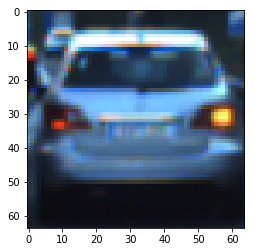

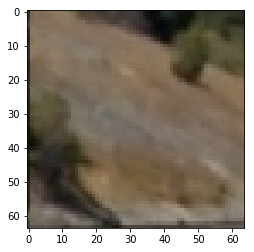

In [25]:
# Get two example images
example_car = mpimg.imread(car_images[0])
example_noncar = mpimg.imread(noncar_images[0])
plt.imshow(example_car)
plt.show()
plt.imshow(example_noncar)
plt.show()

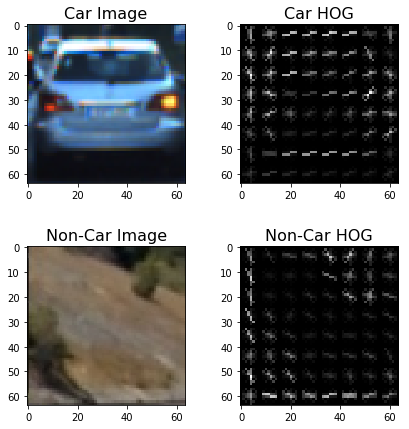

In [231]:
# Exact HOG features of the two test images
car_features,car_hog = get_hog_features(example_car[:,:,2], 9, 8, 2, vis=True, feature_vec=True)
noncar_features,noncar_hog = get_hog_features(example_noncar[:,:,2], 9, 8, 2, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(example_car)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_hog, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(example_noncar)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_hog, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
plt.show()


## Train a SVM classifier with extracted features

In [36]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split




# Divide up into cars and notcars
cars = []
notcars = []
for image in car_images:
    cars.append(image)
for image in noncar_images:
    notcars.append(image)

# Reduce the sample size because HOG features are slow to compute

#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 20
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

/home/cao/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


69.48 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
20.26 Seconds to train SVC...
Test Accuracy of SVC =  0.9899
My SVC predicts:      [ 1.  1.  1.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.  1.  1.  0.  0.
  0.  0.]
For these 20 labels:  [ 1.  1.  1.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.  1.  1.  0.  0.
  0.  0.]
0.00242 Seconds to predict 20 labels with SVC


## Sliding window search

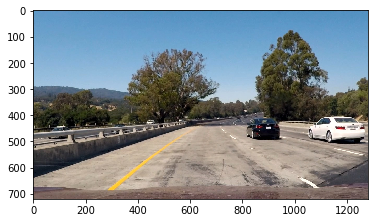

In [37]:
img = mpimg.imread('test_images/test1.jpg')
plt.imshow(img)
plt.show()

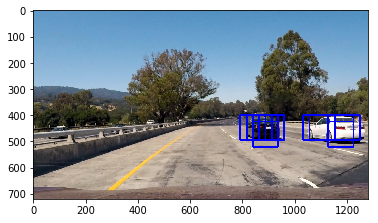

In [243]:

svc = svc
X_scaler = X_scaler
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_bins = 32

ystart = 400
ystop = 650
xstart = 600
scale = 1.5


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img,svc, X_scaler, ystart=400, ystop=656, xstart=600, scale=1.5, \
              orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32,32), hist_bins=32):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart::,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    xboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 
                xboxes.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
    return draw_img,xboxes


    
out_img,xboxes = find_cars(img, svc, X_scaler,  ystart, ystop, xstart)

plt.imshow(out_img)
plt.show()

In [253]:
from scipy.ndimage.measurements import label
import collections
# Using history information to help detect the vehicles
history_frames = history_frames = collections.deque([],10)

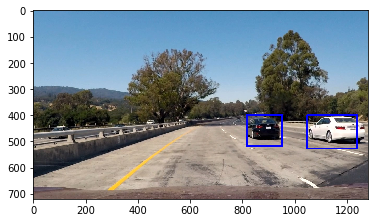

In [255]:


# Read in image similar to one shown above 
image = mpimg.imread('test_images/test1.jpg')


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    history_frames.append(bbox_list)
    for frame in history_frames:  
        for box in frame:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def annotate_img(image):
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    cboxes=[]
    img,boxes = find_cars(image,svc,X_scaler,scale=1)
    for box in boxes:
        cboxes.append(box)
    img,boxes = find_cars(image,svc,X_scaler,scale=1.5)
    for box in boxes:
        cboxes.append(box)
    img,boxes = find_cars(image,svc,X_scaler,scale=2)
    for box in boxes:
        cboxes.append(box)
    # Add heat to each box in box list
    heat = add_heat(heat,cboxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,np.ceil(len(history_frames)))
    #heat = apply_threshold(heat,len(history_frames))

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
        
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

draw_img = annotate_img(image)
plt.imshow(draw_img)
plt.show()



## Process video

In [251]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
history_frames.clear()
test_out_file = 'project_with_lane_out.mp4'
clip_test = VideoFileClip('lane_video.mp4')#.subclip(40,50)
clip_test_out = clip_test.fl_image(annotate_img)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_out.mp4
[MoviePy] Writing video test_out.mp4



 12%|█▏        | 152/1261 [01:28<10:42,  1.73it/s]


 24%|██▍       | 303/1261 [02:56<09:16,  1.72it/s]


 36%|███▌      | 454/1261 [04:25<07:47,  1.73it/s]


 48%|████▊     | 605/1261 [05:54<06:13,  1.75it/s]


 60%|█████▉    | 756/1261 [07:23<05:00,  1.68it/s]


 72%|███████▏  | 907/1261 [08:53<03:32,  1.66it/s]


 84%|████████▍ | 1057/1261 [10:22<01:57,  1.73it/s]


 96%|█████████▌| 1205/1261 [11:47<00:32,  1.73it/s]


100%|█████████▉| 1260/1261 [12:19<00:00,  1.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_out.mp4 

CPU times: user 20min 28s, sys: 3.02 s, total: 20min 31s
Wall time: 12min 20s
